# Two-body twisted boundary conditions

This notebook provides a minimal description how to implement twisted boundary conditions for a non-relativistc two-body quantum system following the publication [[1511.06598]](https://arxiv.org/abs/1511.06598v1).

## Initialization

In [1]:
# Python modules
import itertools
from dataclasses import dataclass
from dataclasses import field
from typing import Dict
import time

# Numerical modules
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as lina
import scipy.optimize as opt

# Data handeling
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pylab as plt

# Fitting
import lsqfit
import gvar as gv

%load_ext blackcellmagic

### Parameters

In [2]:
HBARC = 197.326 # MeV / fm
E_DEUTERON = - 2.225 / HBARC
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC

NDIM_MAX = 3
N1D_MAX = 20
LATTICE_SPACING = 1.97

# Introduction

### Kinetic Hamiltonian

In [ ]:
def get_kinetic_hamiltonian(
    n1d_max: int,
    twist_angle: float = 0.0,
    lattice_spacing: float = 1.0,
    particle_mass: float = M_NUCLEON,
    ndim_max: int = 3,
    derivative_shifts: Dict[int, float] = {-1: 1.0, 0: -2.0, 1: 1.0},
) -> sp.csr_matrix:
    """Computes the kinetic Hamiltonian for a relative two-body system in a 3D box.
    
    The kinetic Hamiltonian is defined by
        `H0 = - Laplace / 2 /(2 particle_mass)` 
    Where Laplace is the lattice laplace operator with twisted boundary conditions.
    
    Arguments
    ---------
        n1d_max: int
            Spatial dimension of lattice in any direction.
        
        twist_angle: float
            The total amount of twist.
            
        lattice_spacing: float
            The lattice spacing in fermi.
            
        particle_mass: float
            The mass of the particles to be described in inverse fermi.
        
        ndim_max: float
            The number of spatial dimensions.
        
        derivative_shifts: Dict[int, float]
            The implementation of the numerical laplace operator.
            E.g., for a one step derivative 
                `d2f/dx2(n) = sum(
                    c_i * f(n + s_i) * exp(1j * twist_angle/n1d_max * s_i)
                )/lattice_spacing**2`
            where s_i and c_i are the keys and values of derivative_shifts.
            
            
    """
    data = sp.lil_matrix((n1d_max ** ndim_max, n1d_max ** ndim_max), dtype=complex)

    modified_shifts = {
        key: val
        / lattice_spacing ** 2
        / 2
        / (particle_mass / 2)
        * np.exp(1j * twist_angle / n1d_max * key)
        for key, val in derivative_shifts.items()
    }

    for nr in range(n1d_max ** ndim_max):
        nr_subtracted = nr
        n1d_pow_ndim = 1

        for ndim in range(ndim_max):
            nxi = (nr_subtracted % (n1d_pow_ndim * n1d_max)) // n1d_pow_ndim
            nr_subtracted -= nxi * n1d_pow_ndim

            for shift, coeff in modified_shifts.items():
                nr_shift = nr + n1d_pow_ndim * (
                    -nxi + (nxi + shift + n1d_max * 10) % n1d_max
                )
                data[(nr, nr_shift)] -= coeff

            n1d_pow_ndim *= n1d_max

    return data.tocsr()


## Potential

In [4]:
def get_full_hamiltonian(
    kinetic_hamiltonian: sp.csr_matrix, contact_strength: float
) -> sp.csr_matrix:
    """Copies the kinetic Hamiltonian and subtracts contact_strength from the (0, 0) component.
    
    Computes `H = H0 + V`, where `V = contact_strength * delta(nr, 0)` and `nr` is ther relative
    distance in the two particle system.
    
    Arguments
    ---------
        kinetic_hamiltonian: sparse matrix
            The kinetic two-body lattice Hamiltonian.
            
        contact_strength: float
            The strength of the contact interaction in respective units.
            This depends on the dimension of the problem, e.g., [fm]**(-1 - ndim).
    """
    hamiltonian = kinetic_hamiltonian.copy()
    hamiltonian[0, 0] += contact_strength
    return hamiltonian


## Solver

A helper class which is used for computing the eigenvalues 

In [218]:
@dataclass
class Solver:
    """Solver for fast eigenvalue access depending on contact interaction strength.
    """

    n1d_max: int
    twist_angle: float = 0.0
    lattice_spacing: float = 1.0
    particle_mass: float = M_NUCLEON
    ndim_max: int = 3
    derivative_shifts: Dict[int, float] = field(
        default_factory=lambda: {
            -4: -1.0 / 560.0,
            -3: 8.0 / 315.0,
            -2: -1.0 / 5.0,
            -1: 8.0 / 5.0,
            +0: -205.0 / 72.0,
            +1: 8.0 / 5.0,
            +2: -1.0 / 5.0,
            +3: 8.0 / 315.0,
            +4: -1.0 / 560.0,

        }
    )
    kinetic_hamiltonian: sp.lil_matrix = field(init=False, repr=False)

    def __post_init__(self):
        self.kinetic_hamiltonian = get_kinetic_hamiltonian(
            self.n1d_max,
            self.twist_angle,
            self.lattice_spacing,
            self.particle_mass,
            self.ndim_max,
            self.derivative_shifts,
        )

    def get_ground_state(self, contact_strength: float, **kwargs) -> float:
        """Returns smallest algebraic eigenvalue in of Hamiltonian in `[fm]`
        
        Arguments
        ---------
            contact_strength: float
                The strength of the contact interaction in respective units.
                This depends on the dimension of the problem, e.g., [fm]**(-1 - ndim).
                
            kwargs:
                Additional keyword arguments passed to `eigsh` solver.
        """
        H = get_full_hamiltonian(self.kinetic_hamiltonian, contact_strength)
        return lina.eigsh(H, k=1, which="SA", **kwargs)[0][0]


## Fit to deuteron binding energy

The contact interaction strength is fitted to binding energies at large volumes.

The ground state wave function is of the form
$$
    f(r) \sim \frac{\exp\{-\kappa r\}}{r} \, , \quad \kappa^2 = M_N | E_B| \, .
$$
This information can be used to accelerate computation by making an educated guess for the ground state:

In [256]:
r = []
for nxi in itertools.product(*[range(N1D_MAX)] * NDIM_MAX):
    r.append(np.sqrt(np.sum(np.array(nxi) ** 2)) * LATTICE_SPACING)
r = np.array(r)

kappa = np.sqrt(M_NUCLEON * abs(E_DEUTERON))

psi0 = np.exp(-kappa * r) / (r + 1.e-7)
psi0 /= np.sqrt(psi0 @ psi0)

**This might take a while**

In [257]:
solver = Solver(n1d_max=N1D_MAX, ndim_max=NDIM_MAX, lattice_spacing=LATTICE_SPACING)
res = opt.minimize(
    lambda c: (solver.get_ground_state(c, v0=psi0) - E_DEUTERON)**2, -10.0
)
C0 = res.x[0]

H = get_full_hamiltonian(solver.kinetic_hamiltonian, C0)
fitted_ground_state = lina.eigsh(H, k=1, which="SA")[0][0]*HBARC

print(f"Contact strength: {C0:1.4e} with ground state {fitted_ground_state:1.3f} [MeV]")

Contact strength: -3.1676e-01 with ground state -2.225 [MeV]


## Twist computation

In [279]:
data = []

for n1d in range(2, N1D_MAX, 2):
    print(n1d)
    for twist_angle in np.linspace(0, 2*np.pi, 21):
        solver = Solver(
            n1d_max=n1d,
            ndim_max=NDIM_MAX,
            lattice_spacing=LATTICE_SPACING,
            twist_angle=twist_angle,
        )

        t_start = time.time_ns()

        EL = solver.get_ground_state(C0)

        t_end = time.time_ns()

        data.append(
            {
                "E_L": EL*HBARC,
                "n1d": n1d,
                "twist_angle": twist_angle/np.pi,
                "L": n1d * LATTICE_SPACING,
                "cpu_time": (t_end - t_start) / 10 ** 9,
            }
        )

df = pd.DataFrame(data)

df.head()

2
4
6
8
10
12
14
16
18


,E_L,L,cpu_time,n1d,twist_angle
0,-14.639848,3.94,0.001938,2,0.0
1,-13.986749,3.94,0.001457,2,0.1
2,-12.051129,3.94,0.000960,2,0.2
3,-8.912378,3.94,0.000724,2,0.3
4,-4.733997,3.94,0.001115,2,0.4


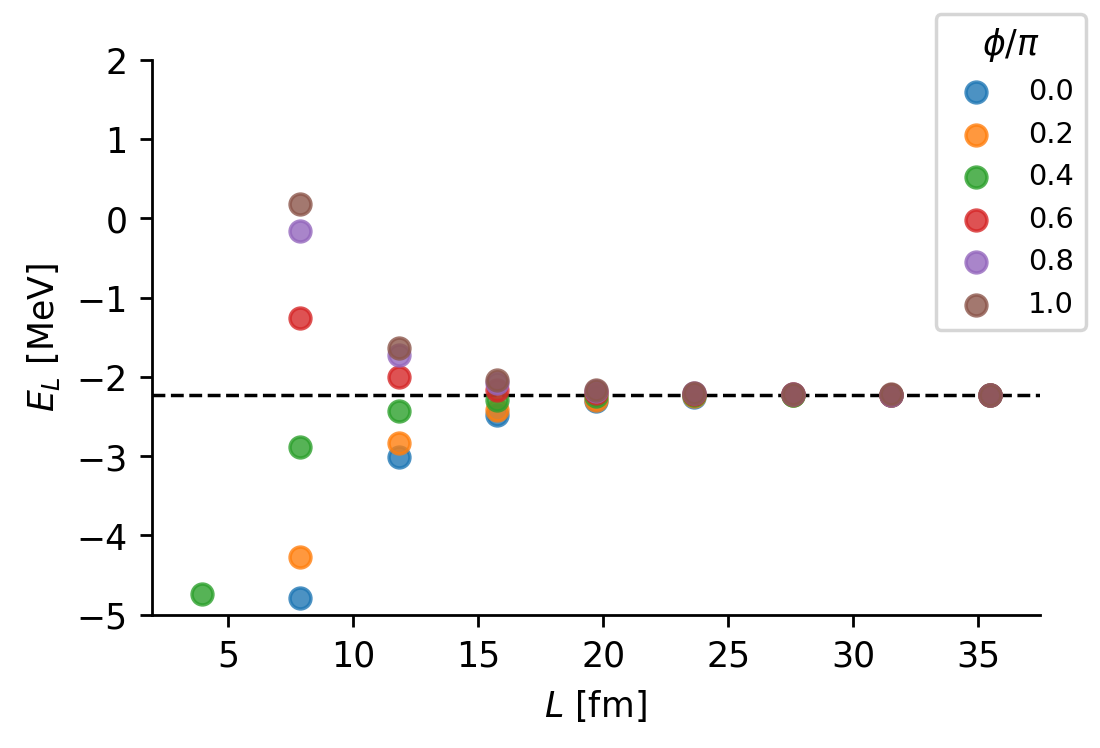

In [361]:
g = sns.lmplot(
    x="L",
    y="E_L",
    hue="twist_angle",
    data=df.where( (df.twist_angle * 10) % 2 != 1).query("twist_angle <= 1.0"),
    fit_reg=False,
    legend=False,
    height=3,
    aspect=1.5,
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("$L$ [fm]", "$E_L$ [MeV]")
g.fig.set_dpi(250)
g.fig.legend(title="$\phi / \pi$", loc="upper right", fontsize="small")

g.ax.axhline(E_DEUTERON*HBARC, ls="--", color="black", zorder=-1, lw=1)
g.ax.set_ylim(-5, 2)

plt.show(g)

## Fitting

In [340]:
def multi_exp(L, pars):
    """
    """
    y = pars["E0"]
    
    g0 = gv.sqrt( -pars["E0"] / HBARC * M_NUCLEON)
    y += pars["A0"] * gv.exp(-g0 * L) / L /  g0
    y += pars["A1"] * gv.exp(-g0*np.sqrt(2) * L) / L /  g0
    y += pars["A2"] * gv.exp(-g0 * L) / L**2 /g0**2
    return y

    
   
def make_prior():
    """
    """
    return {
        "E0": gv.gvar(-3.0, 5.0),
        "A0": gv.gvar(0.0, 100.0),
        "A2": gv.gvar(0.0, 100.0),
        "A1": gv.gvar(0.0, 50.0),
    }

multi_exp(df.L.unique(), make_prior())

array([-3(46), -3.0(8.1), -3.0(5.2), -3.0(5.0), -3.0(5.0), -3.0(5.0),
       -3.0(5.0), -3.0(5.0), -3.0(5.0)], dtype=object)

In [362]:
fit_res = []

for twist_angle in df.twist_angle.unique():
    fit_data = df.query("twist_angle == @twist_angle")


    res = lsqfit.nonlinear_fit(
        data=(
            fit_data.L.values,
            gv.gvar(fit_data.E_L.values, [0.005] * fit_data.E_L.values.size),
        ),
        fcn=multi_exp,
        prior=make_prior(),
    )
    res.p["twist_angle"] = twist_angle
    res.p["chi2dof"] = res.chi2 / res.dof
    fit_res.append(res.p)
    
fit_df = pd.DataFrame(fit_res)
fit_df

,A0,A1,A2,E0,chi2dof,twist_angle
0,-41.87(69),47.3(2.8),-17.1(1.1),-2.2216(24),0.363002,0.0
1,-39.43(69),43.7(2.8),-15.7(1.1),-2.2219(24),0.318135,0.1
2,-32.58(70),34.1(2.8),-11.9(1.1),-2.2225(24),0.205795,0.2
3,-22.68(71),21.5(2.9),-6.6(1.2),-2.2233(24),0.086567,0.3
4,-11.66(73),9.5(2.9),-0.5(1.2),-2.2241(24),0.019512,0.4
5,-1.43(74),0.08(2.94),6.2(1.2),-2.2245(24),0.004390,0.5
6,6.92(76),-8.3(3.0),14.5(1.2),-2.2244(24),0.010738,0.6
7,13.25(77),-17.3(3.0),23.9(1.2),-2.2241(24),0.033771,0.7
8,17.75(78),-25.8(3.0),32.3(1.2),-2.2238(24),0.069485,0.8
9,20.46(78),-31.5(3.0),37.6(1.2),-2.2236(24),0.101724,0.9


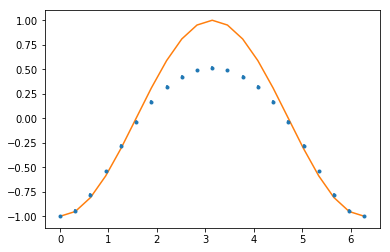

In [363]:
angles = fit_df.twist_angle * np.pi
plt.errorbar(
    angles,
    -gv.mean(fit_df.A0.values) / gv.mean(fit_df.A0.iloc[0]),
    gv.sdev(fit_df.A0.values) / gv.mean(fit_df.A0.iloc[0]),
    marker=".",
    ls="None",
)
plt.plot(angles, -np.cos(angles))


<ErrorbarContainer object of 3 artists>

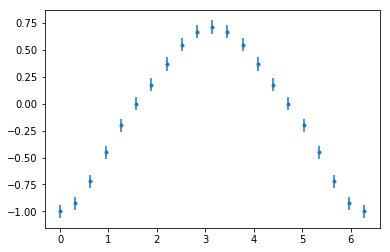

In [364]:
plt.errorbar(
    angles,
    -gv.mean(fit_df.A1.values) / gv.mean(fit_df.A1.iloc[0]),
    gv.sdev(fit_df.A1.values) / gv.mean(fit_df.A1.iloc[0]),
    marker=".",
    ls="None",
)

<ErrorbarContainer object of 3 artists>

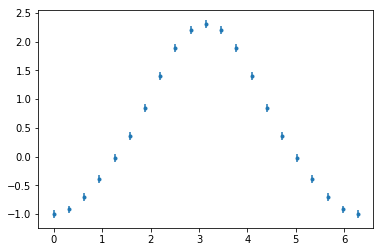

In [365]:
plt.errorbar(
    angles,
    -gv.mean(fit_df.A2.values) / gv.mean(fit_df.A2.iloc[0]),
    gv.sdev(fit_df.A2.values) / gv.mean(fit_df.A2.iloc[0]),
    marker=".",
    ls="None",
)

<ErrorbarContainer object of 3 artists>

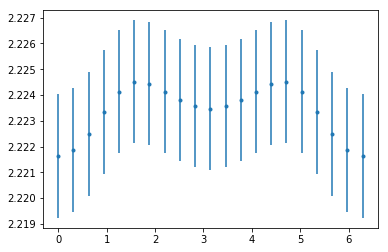

In [366]:
angles = fit_df.twist_angle * np.pi
plt.errorbar(
    angles,
    -gv.mean(fit_df.E0.values),
    gv.sdev(fit_df.E0.values),
    marker=".",
    ls="None",
)

